<h1>Spacial density of Na and K in various traps</h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from typing import Union
from astropy.units import Quantity
from typing import Union, Sequence

from astropy.constants import hbar, k_B

from LightMat import BoseGas, FermiGas, ParticleProps

import scipy
from tqdm import tqdm

In [2]:
def ring_beam_trap(
        X: Union[float, np.ndarray],
        Y: Union[float, np.ndarray],
        Z: Union[float, np.ndarray],
        ring_radius: float = 60.0,
        waist_xy: float = 6.0,
        waist_z: float = 14.0,
        flat_z: float = 68.0,
        blue_trap_height: float = 38*0.65,  #300.0, # 38 mW * 0.65 ring
        red_trap_depth: float = 190*0.07, #100.0, # 190 mW * 0.07 paint
        inhom_ring: float = 0.002,
        inhom_paint: float = 0.0008,
        central_height: float = 100.0,
        seed: int = 42,     # T_sodium = 
                            # T_potassium = 100nK
                            # N
        
        #group meeting slide 043024
):
    # Ensure X, Y, Z are numpy arrays
    if isinstance(X, Quantity) and X.unit.is_equivalent(u.um):
        X = X.to(u.um).value
    if isinstance(Y, Quantity) and Y.unit.is_equivalent(u.um):
        Y = Y.to(u.um).value
    if isinstance(Z, Quantity) and Z.unit.is_equivalent(u.um):
        Z = Z.to(u.um).value
    X = np.atleast_1d(X)
    Y = np.atleast_1d(Y)
    Z = np.atleast_1d(Z)
    
    # Calculate radial distance from the center (0, 0) for each point
    R = np.sqrt(X**2 + Y**2)
    # Setting potential to max value outside the ring
    Vxy = np.full_like(R, blue_trap_height)
    # Within the ring, calculate the Gaussian profile
    inside_ring = R <= (ring_radius)
    Vxy[inside_ring] = blue_trap_height * np.exp(-2 * (R[inside_ring] - ring_radius)**2 / waist_xy**2)
    
    # Create box trap profile with Gaussian edges for Z direction
    gaussian_edges_z = np.exp(-2 * (np.abs(Z) - flat_z / 2)**2 / waist_z**2)
    Vz = -red_trap_depth * gaussian_edges_z / gaussian_edges_z.max()
    Vz[np.abs(Z) <= flat_z / 2] = -red_trap_depth

    # Add noise
    np.random.seed(seed)
    noise_ring = np.random.uniform(-1, 1, Vxy.shape) * inhom_ring * Vxy
    Vxy = Vxy + noise_ring
    noise_paint = np.random.uniform(-1, 1, Vz.shape) * inhom_paint * Vz
    Vz = Vz + noise_paint

    # Combine the XY and Z potentials
    V_trap = Vxy + Vz

    #central_waist = 5
    #central_gaussian = np.exp(-2 * (R**2 + Z**2) / central_waist**2)
    #V_trap += central_height * central_gaussian / np.max(central_gaussian)

    return V_trap

In [3]:
blue_trap_height_K = 1000/3   # for Na: *3
red_trap_depth_K = 90*17 # for Na: /17
inhom = 0.005
central_height = 0

k40 = ParticleProps(
    name="K40",
    species="fermion",
    m=39.963999*u.u,
    N_particles=90000,
    T=0*u.nK,
    domain=[(-135, 150), (-135, 135), (-60, 60)] * u.um,
    #V_trap=harmonic_trap,
    #V_trap=box_trap,
    #V_trap=box_2d_harmonic_1d_trap,
    #trap_depth=17*100,
    #box_width=(100,100,100),
    #waist=50,
    V_trap=ring_beam_trap,
    blue_trap_height=blue_trap_height_K,
    red_trap_depth=red_trap_depth_K,
    central_height=central_height,
    #inhomogeneity=inhom,
)

na23 = ParticleProps(
    name="Na23",
    species="boson",
    m=22.989768*u.u,
    N_particles=114000,
    T=0*u.nK,
    a_s=2.75*u.nm,
    domain=[(-135, 135), (-135, 135), (-60, 60)] * u.um,
    #V_trap=harmonic_trap,
    #V_trap=box_trap,
    #V_trap=box_2d_harmonic_1d_trap,
    #trap_depth=100,
    #box_width=(100,100,100),
    #waist=50,
    V_trap=ring_beam_trap,
    blue_trap_height=3*blue_trap_height_K,
    red_trap_depth=red_trap_depth_K/17,
    central_height=central_height,
    #inhomogeneity=inhom,
)

#k40.plot_V_trap()
#na23.plot_V_trap()

In [4]:
fg = FermiGas(k40)
fg.eval_density(use_TF_or_LDA=True)

Calculate n with TF approximation...


  4%|▍         | 39/1000 [00:01<00:33, 29.06it/s]

Convergence reached after 39 iterations.


In [5]:
bg = BoseGas(na23)
bg.eval_density(use_TF=True)

Calculate n0 with TF approximation and n_ex with semiclassical HF approximation...


 23%|██▎       | 23/100 [00:00<00:03, 23.28it/s]

Convergence reached after 23 iterations.


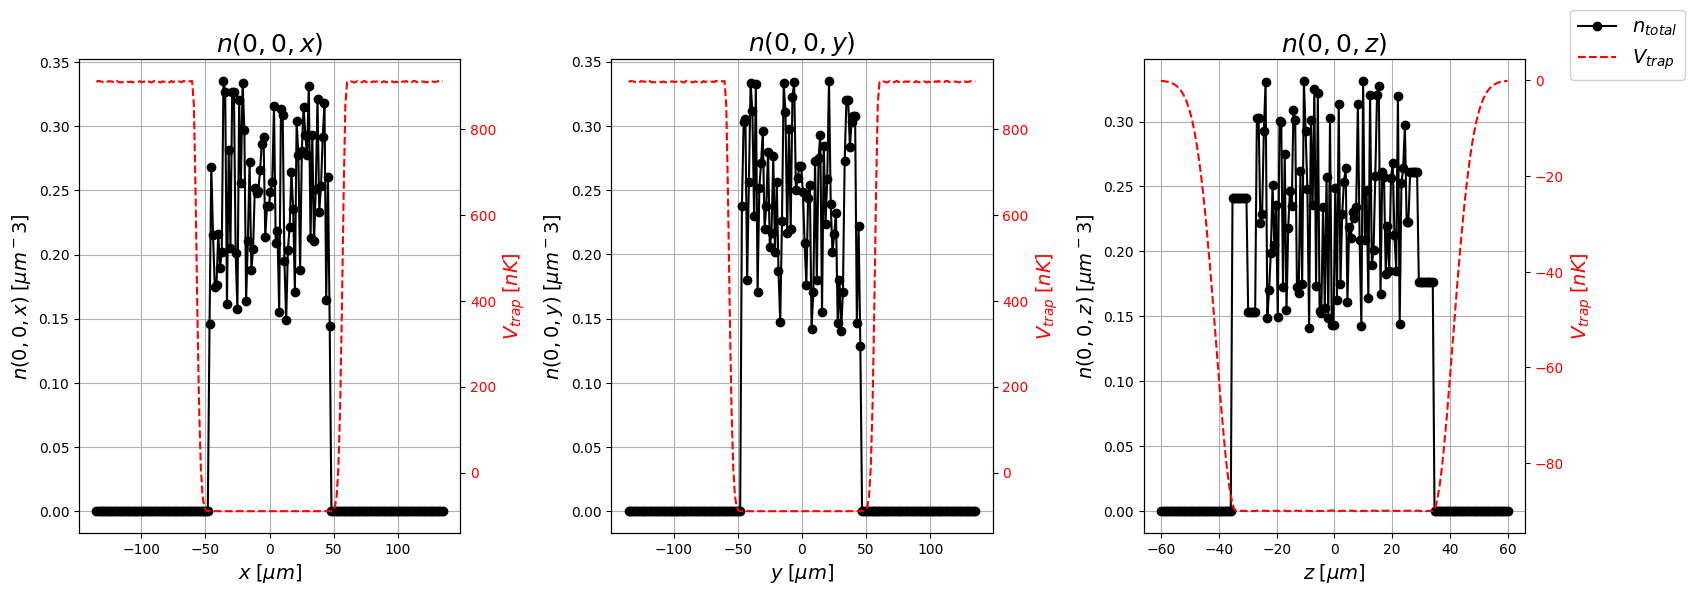

In [6]:
fig = bg.plot_density_1d(which='n', title = "", filename="sodium_density_1d.png")

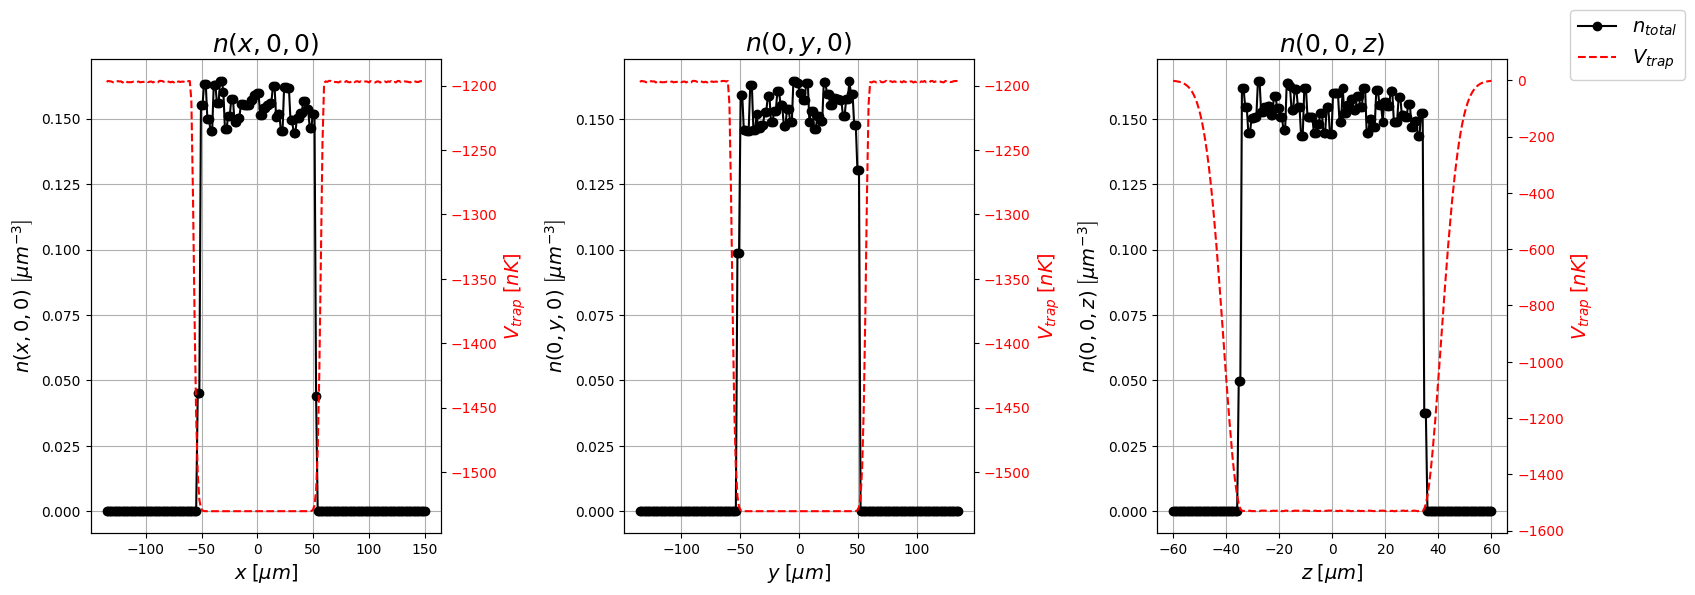

In [7]:
fig = fg.plot_density_1d( title = "", filename="potassium_density_1d.png")

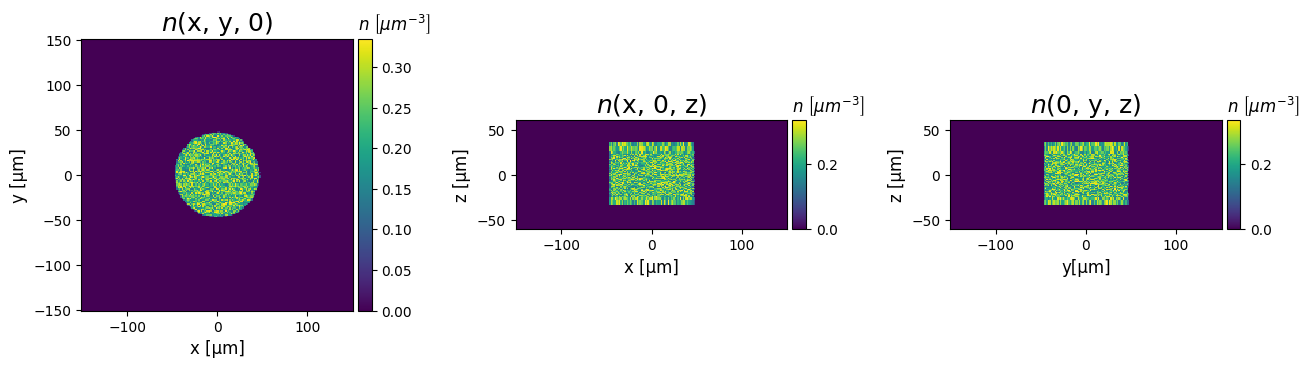

In [8]:
fig = bg.plot_density_2d(which='n', title = "", filename="sodium_density_2d.png")

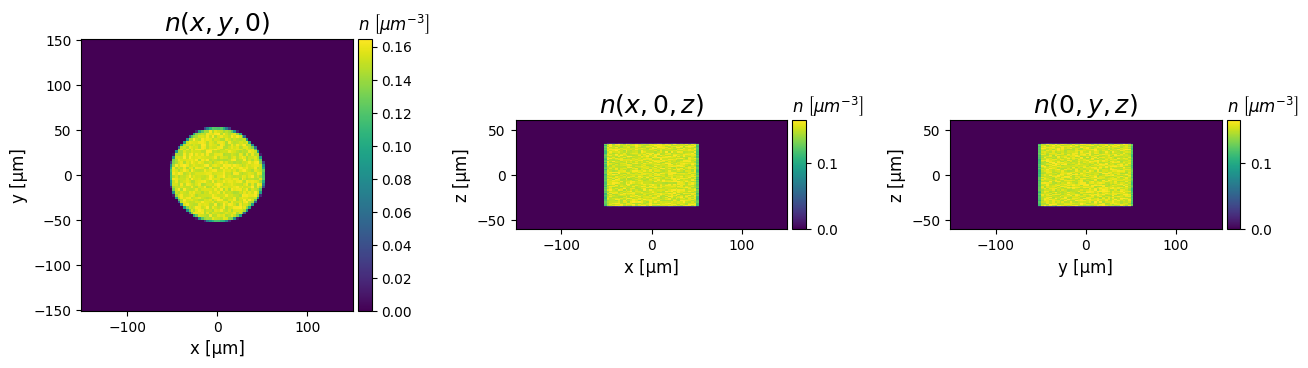

In [9]:
fig = fg.plot_density_2d(title = "", filename="potassium_density_2d.png")

In [10]:
import numpy as np
import matplotlib.pyplot as plt

path = "/home/lelo/Downloads/"

k_data = np.load(path + "density_K.npy")
na_data = np.load(path + "density_Na.npy")

plt.imshow(k_data[:, :, 0])

FileNotFoundError: [Errno 2] No such file or directory: '/home/lelo/Downloads/density_K.npy'

In [ ]:
k_data.shape

(104, 104, 40)

<h2> Density matching </h2>

In [ ]:
num_points = 201

x = np.linspace(fg.particle_props.domain[0, 0].value, fg.particle_props.domain[0, 1].value, num_points)
y = np.linspace(fg.particle_props.domain[1, 0].value, fg.particle_props.domain[1, 1].value, num_points)
z = np.linspace(fg.particle_props.domain[2, 0].value, fg.particle_props.domain[2, 1].value, num_points)

X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

fg_n = fg.spatial_basis_set.expand_coeffs(fg.n_array, X, Y, Z)
bg_n = bg.spatial_basis_set.expand_coeffs(bg.n_array, X, Y, Z)

In [ ]:
def plot_overlap(bg, fg, central_height):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('K40 and Na23 density matching, T=0, N=100000, inhom=' + str(k40.inhomogeneity*100) + "%" + r", $\omega = 5\mu m$, $h="+str(central_height)+r"nK$", fontsize=24)
    fig.tight_layout(pad=1.5)

    axs[0].plot(x, fg_n[:, num_points//2, num_points//2], label='K40 Fermi gas', marker='o')
    axs[0].plot(x, bg_n[:, num_points//2, num_points//2], label='Na23 Bose gas', marker='o')
    axs[0].set_xlabel('x [μm]', fontsize=14)
    axs[0].set_ylabel(r'n [$μm^{-3}$]', fontsize=14)
    axs[0].set_title('n(x, 0, 0)', fontsize=18)
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(y, fg_n[num_points//2, :, num_points//2], label='K40 Fermi gas', marker='o')
    axs[1].plot(y, bg_n[num_points//2, :, num_points//2], label='Na23 Bose gas', marker='o')
    axs[1].set_xlabel('y [μm]', fontsize=14)
    axs[1].set_ylabel(r'n [$μm^{-3}$]', fontsize=14)
    axs[1].set_title('n(0, y, 0)', fontsize=18)
    axs[1].legend()
    axs[1].grid(True)

    axs[2].plot(z, fg_n[num_points//2, num_points//2, :], label='K40 Fermi gas', marker='o')
    axs[2].plot(z, bg_n[num_points//2, num_points//2, :], label='Na23 Bose gas', marker='o')
    axs[2].set_xlabel('z [μm]', fontsize=14)
    axs[2].set_ylabel(r'n [$μm^{-3}$]', fontsize=14)
    axs[2].set_title('n(0, 0, z)', fontsize=18)
    axs[2].legend()
    axs[2].grid(True)

    plt.savefig("./plots/20240130_density_matching_" + str(k40.inhomogeneity*100) + ".png", dpi=300, bbox_inches='tight')

In [ ]:
bgs = []
fgs = []

for central_height in [0, 1, 2, 3, 4, 5]:
    na23 = ParticleProps(
        name="Na23",
        species="boson",
        m=22.989768*u.u,
        N_particles=100000,
        T=0, #15*u.nK,
        a_s=2.75*u.nm,
        domain=(-40, 40)*u.um,
        #V_trap=harmonic_trap,
        #V_trap=box_trap,
        #V_trap=box_2d_harmonic_1d_trap,
        #trap_depth=100,
        #box_width=(100,100,100),
        #waist=50,
        V_trap=ring_beam_trap,
        blue_trap_height=3*blue_trap_height_K,
        red_trap_depth=red_trap_depth_K/17,
        central_height=central_height,
        inhomogeneity=0,
    )

    k40 = ParticleProps(
        name="K40",
        species="fermion",
        m=39.963999*u.u,
        N_particles=100000,
        T=0, #45*u.nK,
        domain=(-40, 40)*u.um,
        #V_trap=harmonic_trap,
        #V_trap=box_trap,
        #V_trap=box_2d_harmonic_1d_trap,
        #trap_depth=17*100,
        #box_width=(100,100,100),
        #waist=50,
        V_trap=ring_beam_trap,
        blue_trap_height=blue_trap_height_K,
        red_trap_depth=red_trap_depth_K,
        central_height=central_height,
        inhomogeneity=0,
    )

    bg = BoseGas(na23)
    bg.eval_density(use_TF=False)
    bgs.append(bg)

    fg = FermiGas(k40)
    fg.eval_density(use_TF_or_LDA=False)
    fgs.append(fg)

   

TypeError: ring_beam_trap() got an unexpected keyword argument 'inhomogeneity'

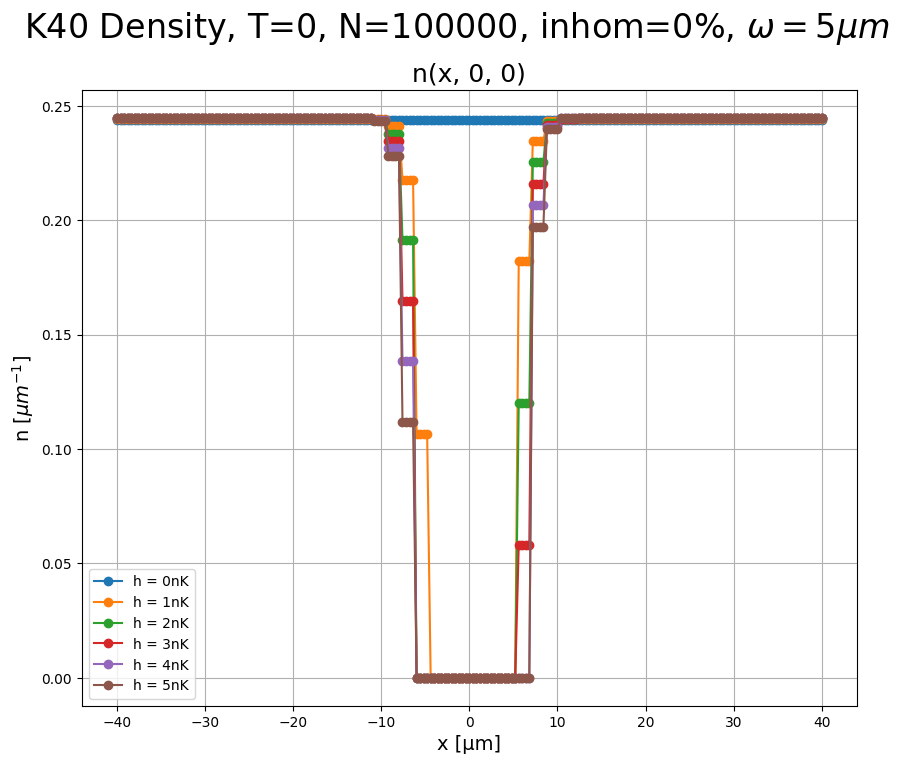

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
fig.suptitle('K40 Density, T=0, N=100000, inhom=0%, $\omega = 5\mu m$', fontsize=24)

ax.set_xlabel('x [μm]', fontsize=14)
ax.set_ylabel(r'n [$μm^{-1}$]', fontsize=14)
ax.set_title('n(x, 0, 0)', fontsize=18)

num_points = 201
x = np.linspace(bgs[0].particle_props.domain[0, 0].value, bgs[0].particle_props.domain[0, 1].value, num_points)

for i, height in enumerate([0, 1, 2, 3, 4, 5]):
    ax.plot(x, bgs[i].spatial_basis_set.expand_coeffs(bgs[i].n_array, x, 0, 0), label='h = ' + str(height) + 'nK', marker='o')

ax.legend()
ax.grid(True)